In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

In [2]:
df = pd.read_excel(os.getcwd()+'/testA.xlsx')

In [3]:
df = df[['Employee_Name', 'Salary', 'Position', 'State', 'Zip', 'Date of birth',
       'Sex', 'Marital status', 'Citizen status', 'Date of Hire',
       'Term Reason', 'Employment Status', 'Department', 'RecruitmentSource',
       'Performance score', 'Engagement Survey', 'Employee satisfaction',
       'Special Projects Count', 'Days late, last 30', 'Absences']]

In [4]:
df = df.iloc[:311]

In [5]:
df.head()

,Employee_Name,Salary,Position,State,Zip,Date of birth,Sex,Marital status,Citizen status,Date of Hire,Term Reason,Employment Status,Department,RecruitmentSource,Performance score,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences
0,"A'aroni, Noam",62506.0,Production Technician I,MA,1960,1983-10-07 00:00:00,M,Single,US Citizen,2011-05-07 00:00:00,N/A-StillEmployed,Active,Production,LinkedIn,Exceeds,4.60,5.0,0.0,0.0,1.0
1,"Aidan, Baruch",104437.0,Sr. DBA,MA,2148,1975-05-05 00:00:00,M,Married,US Citizen,3/30/2015,career change,Voluntarily Terminated,IT/IS,Indeed,Fully Meets,4.96,3.0,6.0,0.0,17.0
2,"Akron, Salma",64955.0,Production Technician II,MA,1810,09/19/88,F,Married,US Citizen,2011-05-07 00:00:00,hours,Voluntarily Terminated,Production,LinkedIn,Fully Meets,3.02,3.0,0.0,0.0,3.0
3,"Alame, Charlotte",64991.0,Production Technician I,MA,1886,09/27/88,F,Married,US Citizen,2008-07-01 00:00:00,N/A-StillEmployed,Active,Production,Indeed,Fully Meets,4.84,5.0,0.0,0.0,15.0
4,"Anderson, Erich",50825.0,Production Technician I,MA,2169,1989-08-09 00:00:00,F,Divorced,US Citizen,2011-11-07 00:00:00,return to school,Voluntarily Terminated,Production,Google Search,Fully Meets,5.00,4.0,0.0,0.0,2.0


In [6]:
df.nunique()

Employee_Name             311
Salary                    308
Position                   32
State                      28
Zip                       158
Date of birth             307
Sex                         2
Marital status              5
Citizen status              3
Date of Hire              101
Term Reason                18
Employment Status           3
Department                  6
RecruitmentSource           9
Performance score           4
Engagement Survey         119
Employee satisfaction       5
Special Projects Count      9
Days late, last 30          7
Absences                   20
dtype: int64

In [7]:
df.isna().sum()

Employee_Name              0
Salary                     0
Position                   0
State                      0
Zip                        0
Date of birth              0
Sex                        0
Marital status             0
Citizen status             0
Date of Hire               0
Term Reason               13
Employment Status         13
Department                 0
RecruitmentSource          0
Performance score          0
Engagement Survey          0
Employee satisfaction      0
Special Projects Count     0
Days late, last 30         0
Absences                   0
dtype: int64

In [8]:
df.head()

,Employee_Name,Salary,Position,State,Zip,Date of birth,Sex,Marital status,Citizen status,Date of Hire,Term Reason,Employment Status,Department,RecruitmentSource,Performance score,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences
0,"A'aroni, Noam",62506.0,Production Technician I,MA,1960,1983-10-07 00:00:00,M,Single,US Citizen,2011-05-07 00:00:00,N/A-StillEmployed,Active,Production,LinkedIn,Exceeds,4.60,5.0,0.0,0.0,1.0
1,"Aidan, Baruch",104437.0,Sr. DBA,MA,2148,1975-05-05 00:00:00,M,Married,US Citizen,3/30/2015,career change,Voluntarily Terminated,IT/IS,Indeed,Fully Meets,4.96,3.0,6.0,0.0,17.0
2,"Akron, Salma",64955.0,Production Technician II,MA,1810,09/19/88,F,Married,US Citizen,2011-05-07 00:00:00,hours,Voluntarily Terminated,Production,LinkedIn,Fully Meets,3.02,3.0,0.0,0.0,3.0
3,"Alame, Charlotte",64991.0,Production Technician I,MA,1886,09/27/88,F,Married,US Citizen,2008-07-01 00:00:00,N/A-StillEmployed,Active,Production,Indeed,Fully Meets,4.84,5.0,0.0,0.0,15.0
4,"Anderson, Erich",50825.0,Production Technician I,MA,2169,1989-08-09 00:00:00,F,Divorced,US Citizen,2011-11-07 00:00:00,return to school,Voluntarily Terminated,Production,Google Search,Fully Meets,5.00,4.0,0.0,0.0,2.0


In [9]:
df['Employment Status'].value_counts()

Active                    200
Voluntarily Terminated     82
Terminated for Cause       16
Name: Employment Status, dtype: int64

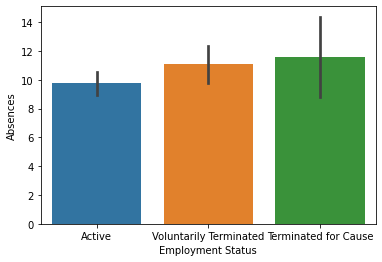

In [10]:
sns.barplot(data = df, x = 'Employment Status', y = 'Absences')
plt.show()

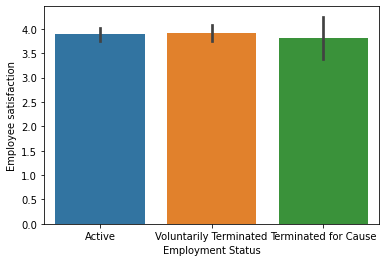

In [11]:
sns.barplot(data = df, x = 'Employment Status', y = 'Employee satisfaction')
plt.show()

In [12]:
df[df['Employment Status'] == 'Terminated for Cause'][['Term Reason']].value_counts()

Term Reason                  
attendance                       6
no-call, no-show                 4
performance                      3
Fatal attraction                 1
Learned that he is a gangster    1
gross misconduct                 1
dtype: int64

In [13]:
df[df['Employment Status'] == 'Terminated for Cause']

,Employee_Name,Salary,Position,State,Zip,Date of birth,Sex,Marital status,Citizen status,Date of Hire,Term Reason,Employment Status,Department,RecruitmentSource,Performance score,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences
15,"Batman, Bruce",57834.0,Production Technician I,MA,2050,10/18/81,M,Single,US Citizen,2/21/2011,attendance,Terminated for Cause,Production,Google Search,Fully Meets,5.00,4.0,0.0,0.0,20.0
18,"Beckler, Daphne",110000.0,Database Administrator,MA,2026,1986-04-04 00:00:00,F,Single,US Citizen,2014-07-07 00:00:00,performance,Terminated for Cause,IT/IS,Google Search,Fully Meets,4.50,4.0,5.0,0.0,8.0
25,"Bond, James",103613.0,Enterprise Architect,CT,6033,07/30/64,M,Single,US Citizen,2/17/2014,Learned that he is a gangster,Terminated for Cause,IT/IS,LinkedIn,Fully Meets,3.50,5.0,7.0,0.0,2.0
53,"Cole, Nat king",59144.0,Production Technician I,MA,1880,1979-12-08 00:00:00,M,Single,US Citizen,2011-11-07 00:00:00,performance,Terminated for Cause,Production,LinkedIn,Needs Improvement,2.00,3.0,0.0,5.0,16.0
84,"Estresano, Alberto",60340.0,Production Technician I,MA,2129,1983-02-09 00:00:00,M,Single,US Citizen,2012-02-04 00:00:00,attendance,Terminated for Cause,Production,Google Search,Needs Improvement,5.00,4.0,0.0,5.0,16.0
85,"Evenesen, Amanda",59124.0,Production Technician I,MA,2458,1989-06-05 00:00:00,F,Single,US Citizen,2/17/2014,"no-call, no-show",Terminated for Cause,Production,Google Search,Needs Improvement,2.30,3.0,0.0,5.0,19.0
86,"Exphar, April",99280.0,Software Engineer,MA,1749,05/15/87,F,Married,US Citizen,2011-02-05 00:00:00,attendance,Terminated for Cause,Software Engineering,Indeed,Needs Improvement,2.10,5.0,4.0,4.0,19.0
95,"Forest, Yannis",70187.0,Area Sales Manager,MA,2330,1975-07-07 00:00:00,M,Married,US Citizen,9/29/2014,Fatal attraction,Terminated for Cause,Sales,Employee Referral,PIP,2.00,5.0,0.0,4.0,7.0
104,"Gill, Annabel",59370.0,Area Sales Manager,OH,43050,1971-10-07 00:00:00,F,Widowed,US Citizen,2014-07-07 00:00:00,attendance,Terminated for Cause,Sales,CareerBuilder,Fully Meets,3.97,4.0,0.0,0.0,7.0
108,"Goblin, Malissa",114800.0,Database Administrator,MA,2127,10/23/71,F,Single,US Citizen,2/16/2015,"no-call, no-show",Terminated for Cause,IT/IS,Indeed,Fully Meets,4.60,4.0,4.0,0.0,10.0


In [14]:
df['Date of birth']  = pd.to_datetime(df['Date of birth'])

In [15]:
today = date.today()
today

datetime.date(2021, 8, 26)

In [16]:
df['age'] = today.year - df['Date of birth'].dt.year

In [17]:
df['Date of Hire'] = pd.to_datetime(df['Date of Hire'])

In [18]:
df['months_at_work'] = today.year*12+today.month - (df['Date of Hire'].dt.month+df['Date of Hire'].dt.year*12)

In [19]:
def zodiac_sign(date):
    month, day = date.month, date.day
    if month == 12:
        astro_sign = 'sagittarius' if (day < 22) else 'capricorn'
    elif month == 1:
        astro_sign = 'capricorn' if (day < 20) else 'aquarius'
    elif month == 2:
        astro_sign = 'aquarius' if (day < 19) else 'pisces'
    elif month == 3:
        astro_sign = 'pisces' if (day < 21) else 'aries'
    elif month == 4:
        astro_sign = 'aries' if (day < 20) else 'taurus'
    elif month == 5:
        astro_sign = 'taurus' if (day < 21) else 'gemini'
    elif month == 6:
        astro_sign = 'gemini' if (day < 21) else 'cancer'
    elif month == 7:
        astro_sign = 'cancer' if (day < 23) else 'leo'
    elif month == 8:
        astro_sign = 'leo' if (day < 23) else 'virgo'
    elif month == 9:
        astro_sign = 'virgo' if (day < 23) else 'libra'
    elif month == 10:
        astro_sign = 'libra' if (day < 23) else 'scorpio'
    elif month == 11:
        astro_sign = 'scorpio' if (day < 22) else 'sagittarius'
    return astro_sign

In [20]:
df['zodiac_sign'] = df['Date of birth'].apply(lambda x:zodiac_sign(x))

In [21]:
df.head()

,Employee_Name,Salary,Position,State,Zip,Date of birth,Sex,Marital status,Citizen status,Date of Hire,...,RecruitmentSource,Performance score,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,months_at_work,zodiac_sign
0,"A'aroni, Noam",62506.0,Production Technician I,MA,1960,1983-10-07,M,Single,US Citizen,2011-05-07,...,LinkedIn,Exceeds,4.60,5.0,0.0,0.0,1.0,38,123,libra
1,"Aidan, Baruch",104437.0,Sr. DBA,MA,2148,1975-05-05,M,Married,US Citizen,2015-03-30,...,Indeed,Fully Meets,4.96,3.0,6.0,0.0,17.0,46,77,taurus
2,"Akron, Salma",64955.0,Production Technician II,MA,1810,1988-09-19,F,Married,US Citizen,2011-05-07,...,LinkedIn,Fully Meets,3.02,3.0,0.0,0.0,3.0,33,123,virgo
3,"Alame, Charlotte",64991.0,Production Technician I,MA,1886,1988-09-27,F,Married,US Citizen,2008-07-01,...,Indeed,Fully Meets,4.84,5.0,0.0,0.0,15.0,33,157,libra
4,"Anderson, Erich",50825.0,Production Technician I,MA,2169,1989-08-09,F,Divorced,US Citizen,2011-11-07,...,Google Search,Fully Meets,5.00,4.0,0.0,0.0,2.0,32,117,leo


In [22]:
df['Performance score'].unique()

array(['Exceeds', 'Fully Meets', 'Needs Improvement', 'PIP'], dtype=object)

In [23]:
performance = {'Exceeds':4, 'Fully Meets': 3, 'Needs Improvement':2, 'PIP':1}

In [24]:
df['performance_numerical'] = df['Performance score'].apply(lambda x:performance[x])

In [25]:
df.drop(['Employee_Name', 'Date of birth', 'Date of Hire' ,'Zip', 'Performance score', 'Term Reason'], axis = 1, inplace = True)

In [26]:
df['Salary_difference'] = df.apply(lambda x:x.Salary - df[df.Position == x.Position].Salary.median(), axis= 1)    

<AxesSubplot:xlabel='Employment Status', ylabel='Salary_difference'>

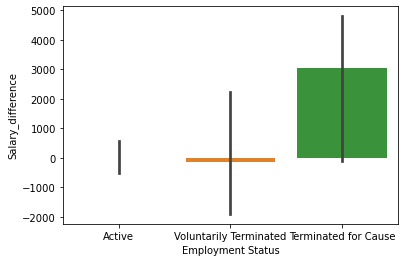

In [27]:
sns.barplot(x = 'Employment Status', y = 'Salary_difference', data = df, estimator = np.median)

In [28]:
df.head()

,Salary,Position,State,Sex,Marital status,Citizen status,Employment Status,Department,RecruitmentSource,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,months_at_work,zodiac_sign,performance_numerical,Salary_difference
0,62506.0,Production Technician I,MA,M,Single,US Citizen,Active,Production,LinkedIn,4.60,5.0,0.0,0.0,1.0,38,123,libra,4,7081.0
1,104437.0,Sr. DBA,MA,M,Married,US Citizen,Voluntarily Terminated,IT/IS,Indeed,4.96,3.0,6.0,0.0,17.0,46,77,taurus,3,2203.0
2,64955.0,Production Technician II,MA,F,Married,US Citizen,Voluntarily Terminated,Production,LinkedIn,3.02,3.0,0.0,0.0,3.0,33,123,virgo,3,-40.0
3,64991.0,Production Technician I,MA,F,Married,US Citizen,Active,Production,Indeed,4.84,5.0,0.0,0.0,15.0,33,157,libra,3,9566.0
4,50825.0,Production Technician I,MA,F,Divorced,US Citizen,Voluntarily Terminated,Production,Google Search,5.00,4.0,0.0,0.0,2.0,32,117,leo,3,-4600.0


In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
df.dtypes

Salary                    float64
Position                   object
State                      object
Sex                        object
Marital status             object
Citizen status             object
Employment Status          object
Department                 object
RecruitmentSource          object
Engagement Survey         float64
Employee satisfaction     float64
Special Projects Count    float64
Days late, last 30        float64
Absences                  float64
age                         int64
months_at_work              int64
zodiac_sign                object
performance_numerical       int64
Salary_difference         float64
dtype: object

In [31]:
df.nunique()

Salary                    308
Position                   32
State                      28
Sex                         2
Marital status              5
Citizen status              3
Employment Status           3
Department                  6
RecruitmentSource           9
Engagement Survey         119
Employee satisfaction       5
Special Projects Count      9
Days late, last 30          7
Absences                   20
age                        47
months_at_work             68
zodiac_sign                12
performance_numerical       4
Salary_difference         285
dtype: int64

In [32]:
df.groupby('Employment Status').mean()

,Salary,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,months_at_work,performance_numerical,Salary_difference
Employment Status,,,,,,,,,,
Active,69802.045000,4.118050,3.885000,1.38500,0.300000,9.775000,29.820000,95.285000,3.020000,104.140000
Terminated for Cause,75264.875000,3.596875,3.812500,1.93750,2.062500,11.562500,34.750000,99.625000,2.500000,1933.843750
Voluntarily Terminated,64356.207317,4.167805,3.914634,0.54878,0.378049,11.097561,31.768293,117.073171,2.963415,-49.615854


In [33]:
df['Employment Status'].value_counts()

Active                    200
Voluntarily Terminated     82
Terminated for Cause       16
Name: Employment Status, dtype: int64

In [34]:
df['Employment Status']=np.where(df['Employment Status'] =='Voluntarily Terminated', 'Inactive', df['Employment Status'])
df['Employment Status']=np.where(df['Employment Status'] =='Terminated for Cause', 'Inactive', df['Employment Status'])

In [35]:
df['State'].value_counts()

MA    276
CT      6
TX      3
VT      2
NY      1
AL      1
FL      1
KY      1
ID      1
NV      1
NC      1
OH      1
NH      1
CO      1
ME      1
CA      1
GA      1
MT      1
ND      1
UT      1
WA      1
RI      1
VA      1
PA      1
AZ      1
OR      1
IN      1
TN      1
Name: State, dtype: int64

In [36]:
df['State']=np.where(df['State'] !='MA', 'notMA', df['State'])

In [37]:
# table=pd.crosstab(df.State,df['Employment Status'])
# table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

In [38]:
df.head()

,Salary,Position,State,Sex,Marital status,Citizen status,Employment Status,Department,RecruitmentSource,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,months_at_work,zodiac_sign,performance_numerical,Salary_difference
0,62506.0,Production Technician I,MA,M,Single,US Citizen,Active,Production,LinkedIn,4.60,5.0,0.0,0.0,1.0,38,123,libra,4,7081.0
1,104437.0,Sr. DBA,MA,M,Married,US Citizen,Inactive,IT/IS,Indeed,4.96,3.0,6.0,0.0,17.0,46,77,taurus,3,2203.0
2,64955.0,Production Technician II,MA,F,Married,US Citizen,Inactive,Production,LinkedIn,3.02,3.0,0.0,0.0,3.0,33,123,virgo,3,-40.0
3,64991.0,Production Technician I,MA,F,Married,US Citizen,Active,Production,Indeed,4.84,5.0,0.0,0.0,15.0,33,157,libra,3,9566.0
4,50825.0,Production Technician I,MA,F,Divorced,US Citizen,Inactive,Production,Google Search,5.00,4.0,0.0,0.0,2.0,32,117,leo,3,-4600.0


In [39]:
for column in ['State', 'Sex', 'Employment Status']:
        df[column] = LabelEncoder().fit_transform(df[column])

In [40]:
df.drop(['Position'], axis = 1, inplace = True)

In [41]:
df.head()

,Salary,State,Sex,Marital status,Citizen status,Employment Status,Department,RecruitmentSource,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,months_at_work,zodiac_sign,performance_numerical,Salary_difference
0,62506.0,0,1,Single,US Citizen,0,Production,LinkedIn,4.60,5.0,0.0,0.0,1.0,38,123,libra,4,7081.0
1,104437.0,0,1,Married,US Citizen,1,IT/IS,Indeed,4.96,3.0,6.0,0.0,17.0,46,77,taurus,3,2203.0
2,64955.0,0,0,Married,US Citizen,1,Production,LinkedIn,3.02,3.0,0.0,0.0,3.0,33,123,virgo,3,-40.0
3,64991.0,0,0,Married,US Citizen,0,Production,Indeed,4.84,5.0,0.0,0.0,15.0,33,157,libra,3,9566.0
4,50825.0,0,0,Divorced,US Citizen,1,Production,Google Search,5.00,4.0,0.0,0.0,2.0,32,117,leo,3,-4600.0


In [42]:
cat_df = df.select_dtypes(include=['object']).copy()

In [43]:
cat_df_dummy = pd.get_dummies(cat_df, columns=cat_df.columns)

In [44]:
cat_df_dummy.head()

,Marital status_Divorced,Marital status_Married,Marital status_Separated,Marital status_Single,Marital status_Widowed,Citizen status_Eligible NonCitizen,Citizen status_Non-Citizen,Citizen status_US Citizen,Department_Admin Offices,Department_Executive Office,...,zodiac_sign_cancer,zodiac_sign_capricorn,zodiac_sign_gemini,zodiac_sign_leo,zodiac_sign_libra,zodiac_sign_pisces,zodiac_sign_sagittarius,zodiac_sign_scorpio,zodiac_sign_taurus,zodiac_sign_virgo
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [45]:
# df = pd.concat([df.drop(cat_df.columns, axis = 1), cat_df_dummy])

In [51]:
df = df.drop(cat_df.columns, axis = 1).join(cat_df_dummy)

In [53]:
df.head()

,Salary,State,Sex,Employment Status,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,...,zodiac_sign_cancer,zodiac_sign_capricorn,zodiac_sign_gemini,zodiac_sign_leo,zodiac_sign_libra,zodiac_sign_pisces,zodiac_sign_sagittarius,zodiac_sign_scorpio,zodiac_sign_taurus,zodiac_sign_virgo
0,62506.0,0,1,0,4.60,5.0,0.0,0.0,1.0,38,...,0,0,0,0,1,0,0,0,0,0
1,104437.0,0,1,1,4.96,3.0,6.0,0.0,17.0,46,...,0,0,0,0,0,0,0,0,1,0
2,64955.0,0,0,1,3.02,3.0,0.0,0.0,3.0,33,...,0,0,0,0,0,0,0,0,0,1
3,64991.0,0,0,0,4.84,5.0,0.0,0.0,15.0,33,...,0,0,0,0,1,0,0,0,0,0
4,50825.0,0,0,1,5.00,4.0,0.0,0.0,2.0,32,...,0,0,0,1,0,0,0,0,0,0


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [64]:
train, test = df.loc[:297,:], df.loc[298:,:]

In [65]:
test

,Salary,State,Sex,Employment Status,Engagement Survey,Employee satisfaction,Special Projects Count,"Days late, last 30",Absences,age,...,zodiac_sign_cancer,zodiac_sign_capricorn,zodiac_sign_gemini,zodiac_sign_leo,zodiac_sign_libra,zodiac_sign_pisces,zodiac_sign_sagittarius,zodiac_sign_scorpio,zodiac_sign_taurus,zodiac_sign_virgo
298,84903.0,0,1,2,3.42,4.0,7.0,0.0,17.0,40,...,0,0,0,1,0,0,0,0,0,0
299,107226.0,0,0,2,4.20,4.0,8.0,0.0,7.0,43,...,0,0,0,0,0,0,0,0,0,0
300,58371.0,0,1,2,5.00,5.0,0.0,0.0,11.0,34,...,0,0,1,0,0,0,0,0,0,0
301,55140.0,0,1,2,5.00,3.0,0.0,0.0,7.0,56,...,0,0,0,0,0,0,0,0,0,1
302,58062.0,0,0,2,3.60,5.0,0.0,0.0,9.0,38,...,0,0,0,1,0,0,0,0,0,0
303,59728.0,0,0,2,4.30,4.0,0.0,0.0,16.0,52,...,0,0,0,0,0,0,0,0,0,0
304,70507.0,0,1,2,5.00,3.0,0.0,0.0,7.0,63,...,1,0,0,0,0,0,0,0,0,0
305,60446.0,0,0,2,3.40,4.0,0.0,0.0,14.0,36,...,0,0,0,0,0,0,0,0,1,0
306,65893.0,0,1,2,4.07,4.0,0.0,0.0,13.0,36,...,0,0,0,0,0,0,0,1,0,0
307,48513.0,0,0,2,3.20,2.0,0.0,5.0,4.0,39,...,0,0,0,0,0,0,0,0,0,0


In [67]:
train_X = train.drop('Employment Status', axis = 1)
train_y = train['Employment Status']

In [68]:
train_y

0      0
1      1
2      1
3      0
4      1
      ..
293    1
294    0
295    0
296    1
297    1
Name: Employment Status, Length: 298, dtype: int64

In [73]:
logmodel = LogisticRegression()
logmodel.fit(train_X.values,  train_y.values)

LogisticRegression()

In [74]:
preds = logmodel.predict(train_X.values)

In [77]:
from sklearn.metrics import plot_confusion_matrix

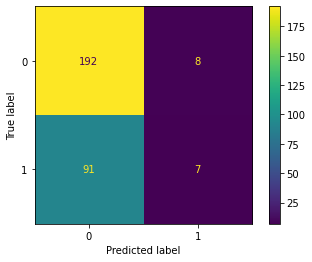

In [79]:
plot_confusion_matrix(logmodel, train_X, train_y)

In [80]:
from sklearn.metrics import classification_report
print(classification_report(train_y,preds))

              precision    recall  f1-score   support

           0       0.68      0.96      0.80       200
           1       0.47      0.07      0.12        98

    accuracy                           0.67       298
   macro avg       0.57      0.52      0.46       298
weighted avg       0.61      0.67      0.57       298

